In [ ]:
!pip install transformers==3.0.0
import gc 
import re 
import numpy as np 
import pandas as pd 
import torch 
import torch.nn as nn 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel, BertModel, BertTokenizer

     |████████████████████████████████| 754 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 51.0 MB/s 
     |████████████████████████████████| 895 kB 61.0 MB/s 
     |████████████████████████████████| 3.0 MB 40.1 MB/s 


In [ ]:
!pip install ipython-autotime
%load_ext autotime


time: 192 µs (started: 2022-01-13 15:27:43 +00:00)


In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive
time: 27min 37s (started: 2022-01-13 15:27:43 +00:00)


In [ ]:
######################
## BERT + CNN MODEL ##
######################


class BERT_CNN (nn.Module):

  def __init__(self, bert):
    super(BERT_CNN, self).__init__()
    self.bert = BertModel.from_pretrained("dbmdz/bert-base-turkish-cased")
    self.conv = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,768), padding="valid") #change chanells if you change number of layers
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(3,1), stride=1)
    self.dropout = nn.Dropout(0.1)
    # be careful here, this needs to be changed according to your max pooling
    #without pooling: 443, with 3x1 pooling:416 for max len 50
    #598 with max len 50 and 3x1 pooling
    self.fc = nn.Linear(552, 3) #because the max_len is 50
    self.flat = nn.Flatten()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, sent_id, mask):
    _,_, all_layers = self.bert(sent_id, attention_mask=mask,
                                output_hidden_states = True) 
    # all_layers = [13, 24, 50, 768]
    # last 4 layers = [4, 24, 50, 768]
    all_layers = all_layers[:-1]
    
    
    x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]),0),0,1)
    
    del all_layers 
    gc.collect()
    torch.cuda.empty_cache()
    x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
    
    x = self.fc(self.dropout(self.flat(self.dropout(x))))
    

    return self.softmax(x)

time: 27.7 ms (started: 2022-01-13 16:11:12 +00:00)


In [ ]:
##################
## READ DATASET ##
##################
import json
train_path = "/content/MyDrive/MyDrive/Data/train.json"
val_path = "/content/MyDrive/MyDrive/Data/validation.json"
test_path = "/content/MyDrive/MyDrive/Data/test.json"
device = "cunda"

with open(train_path, "r") as f:
  train = json.load(f)

with open(val_path,"r") as f: 
  val = json.load(f)

with open(test_path,"r") as f:
  test = json.load(f)

time: 794 ms (started: 2022-01-13 15:55:24 +00:00)


In [ ]:
train = pd.json_normalize(train)
val = pd.json_normalize(val)
test = pd.json_normalize(test)

time: 69.7 ms (started: 2022-01-13 15:55:26 +00:00)


In [ ]:
def read_dataset(data):
  print(len(data))
  return data["sentence"].tolist(), data["value"]

time: 1.38 ms (started: 2022-01-13 15:55:27 +00:00)


In [ ]:
#############################################################
## TOKENIZE AND GET THE INPUT IDS, ATTENTION MASKS, LABELS ##
#############################################################

mapping = {"negative": 0, "neutral":1, "positive":2}
def data_process(data, labels):
  input_ids = []
  attention_mask = []
  sentences = [el for el in data]
  #sentences = [filter(i) for i in sentences]
  y = [mapping[e] for e in labels] 
  tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

  for sentence in sentences:
    bert_inp = tokenizer.__call__(sentence, max_length= 50,
                                  padding = "max_length",
                                  pad_to_max_length=True,
                                  truncation = True,
                                  return_token_type_ids= False)
    input_ids.append(bert_inp["input_ids"])
    attention_mask.append(bert_inp["attention_mask"])

  input_ids = np.asarray(input_ids)
  attention_mask = np.array(attention_mask)
  labels = np.array(y)
  return input_ids, attention_mask, labels 

time: 13.4 ms (started: 2022-01-13 15:55:30 +00:00)


In [ ]:
def load_and_process(data):
  data, labels = read_dataset(data)
  input_ids, attention_masks, labels = data_process(data, labels)
  return input_ids, attention_masks, labels 

time: 1.74 ms (started: 2022-01-13 15:55:33 +00:00)


In [ ]:
##################################
##  FUNCTION TO TRAIN THE MODEL ##
##################################

def train_model():
  model.train()

  total_loss, total_accuracy = 0, 0 

  #empty list to save model predictions
  total_preds = []

  #iterate over batches 
  total = len(train_dataloader) #aşağıda

  for i, batch in enumerate(train_dataloader):

    step = i+1
    percent = "{0:.2f}".format(100 * (step / float(total)))
    lossp = "{0:.2f}".format(total_loss/(total*batch_size))
    filledLength = int(100 * step // total)
    bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
    print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

    #push the batch to gpu 
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch 
    del batch 
    gc.collect()
    torch.cuda.empty_cache()
    # clear previously calculated gradients 
    model.zero_grad()

    #get model prediction for the current batch 
    #send_id = torch.tensor(sent_id).to(device).long()
    preds = model(sent_id, mask)
    

    #compute the loss between actual and predicted values 
    loss = cross_entropy(preds, labels)

    # add on the total loss 
    total_loss += float(loss.item())

    #backward pass to calculate the gradients 
    loss.backward()

    #clip the grafients 1.0 to help preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters 
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU and get all preds 
    total_preds.append(preds.detach().cpu().numpy())

  gc.collect()
  torch.cuda.empty_cache()
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds = np.concatenate(total_preds, axis=0)


  #compute the training loss of the epoch 
  avg_loss = total_loss / (len(train_dataloader) * batch_size)

  

  #returns the loss and predictions 
  return avg_loss, total_preds 



time: 53.2 ms (started: 2022-01-13 15:55:35 +00:00)


In [ ]:
########################## 
## FUNCTION TO EVALUATE ##
########################## 

def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            

             

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()
    

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)
    

    return avg_loss, total_preds

time: 40.6 ms (started: 2022-01-13 15:55:38 +00:00)


In [ ]:
#############################
## LOAD BERT INPUT DATASET ##
#############################

train_input_ids, train_attention_masks, train_labels = load_and_process(train)
train_set = pd.DataFrame(list(zip(train_input_ids, train_attention_masks)), columns=['input_ids', 'attention_masks'])

val_input_ids, val_attention_masks, val_labels = load_and_process(val)
val_set = pd.DataFrame(list(zip(val_input_ids, val_attention_masks)), columns=['input_ids', 'attention_masks'])

test_input_ids, test_attention_masks, test_labels = load_and_process(test)
test_set = pd.DataFrame(list(zip(test_input_ids, test_attention_masks)), columns=['input_ids', 'attention_masks'])



5733


Downloading:   0%|          | 0.00/251k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

639
1592
time: 5.23 s (started: 2022-01-13 15:55:42 +00:00)


In [ ]:
bert = BertModel.from_pretrained("dbmdz/bert-base-turkish-cased")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

time: 11.7 s (started: 2022-01-13 15:55:48 +00:00)


In [ ]:
# for train set 
train_seq = torch.tensor(train_set['input_ids'].tolist())
train_mask = torch.tensor(train_set['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_set['input_ids'].tolist())
val_mask = torch.tensor(val_set['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_set['input_ids'].tolist())
test_mask = torch.tensor(test_set['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())

time: 114 ms (started: 2022-01-13 15:55:59 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
########################
## CREATE DATALOADERS ##
########################

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

time: 10.9 ms (started: 2022-01-13 15:56:00 +00:00)


In [ ]:
print(train_data)

In [ ]:
############################
## FREEZE BERT PARAMETERS ##
############################

for param in bert.parameters():
  param.requires_grad = False 
  

time: 3.7 ms (started: 2022-01-12 19:25:33 +00:00)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda
time: 67 ms (started: 2022-01-13 15:56:00 +00:00)


In [ ]:
# pass the pre-trained BERT to out define artchitecture 
model = BERT_CNN(bert)
# push the model to GPU 
model = model.to(device)

#optimizer from huggingface transformers 
from transformers import AdamW


#define the optimizer 
optimizer = AdamW(model.parameters(), lr= 1e-5)



time: 2.41 s (started: 2022-01-13 16:11:21 +00:00)


In [ ]:
# compute the class weights

from sklearn.utils.class_weight import compute_class_weight

weights = torch.Tensor(compute_class_weight(classes=[0,1,2], y=train_labels, class_weight= "balanced")).to(device)

time: 8.14 ms (started: 2022-01-13 15:56:14 +00:00)


In [ ]:
# loss function 
cross_entropy = nn.NLLLoss( weight = weights) #weightsle de dene bi 

#set initial loss to infinite 
best_valid_loss = float("inf")

epochs = 3
current = 1
#for each epoch 
while current <= epochs:

  print(f'\nEpoch {current} / {epochs}:')

  #train model 
  train_loss, _ = train_model()

  #evaluate model
  valid_loss, _ = evaluate()

  #save the best model 
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss 
    torch.save(model.state_dict(), "saved weights.pth")

  print(f'\n\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')
  #plot the loss 
  

  current = current + 1







Epoch 1 / 3:
Batch 359/359 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.06, accuracy=0

Evaluating...
Batch 40/40 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.04, accuracy=0

Training Loss: 0.058
Validation Loss: 0.046

Epoch 2 / 3:
Batch 359/359 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.04, accuracy=0

Evaluating...
Batch 40/40 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.04, accuracy=0

Training Loss: 0.042
Validation Loss: 0.043

Epoch 3 / 3:
Batch 359/359 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.03, accuracy=0

Evaluating...
Batch 40/40 |█████████████████████████████

In [ ]:
#get predictions for test data 
gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()


print("Performance:")

#model's performance 
preds = np.argmax(preds, axis =1)
print("Classification Report ")
print(classification_report(test_y, preds, digits = 4))

print("Accuracy:" + str(accuracy_score(test_y, preds)))

Performance:
Classification Report 
              precision    recall  f1-score   support

           0     0.6215    0.7036    0.6600       280
           1     0.8545    0.7805    0.8159       843
           2     0.6495    0.6994    0.6735       469

    accuracy                         0.7431      1592
   macro avg     0.7085    0.7278    0.7164      1592
weighted avg     0.7531    0.7431    0.7465      1592

Accuracy:0.7430904522613065
time: 5.22 s (started: 2022-01-13 16:35:16 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[190  38  52]
 [ 61 645 137]
 [ 45  82 342]]


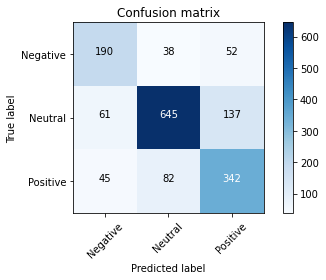

In [ ]:
plt.figure()
plot_confusion_matrix(cnf_boun, classes=["Negative", "Neutral", "Positive"])
plt.savefig("/content/MyDrive/MyDrive/bert_cnn_bounti.png")

In [ ]:
#########################
## İSTANBUL CONVENTION ##
#########################

#LOAD THE DATASET 

ist = pd.read_excel("/content/MyDrive/MyDrive/serraa.xlsx")

ist.head()


,Unnamed: 0,tweet,duygu,Unnamed: 3,Unnamed: 4
0,1,Onca sey oluyor ve benim gercekten icimden ned...,0.0,NaN,NaN
1,2,@cryptoenes0 @SeverLehmacun @solcugazete gezi ...,0.0,NaN,NaN
2,3,Yakında bizi yakmaya da kalkar bunlar. Sürekli...,0.0,NaN,NaN
3,4,"Çok az kaldı çok az. Üzerine koştuğunuz ,bastı...",0.0,NaN,NaN
4,5,@abdulhamitgul Hayvan yasası yeni bir istanbul...,0.0,NaN,NaN


In [1]:
ist_tweet = ist["tweet"][1500].tolist()


NameError: ignored

In [ ]:
ist_labels = [int(i) for i in ist["duygu"][:1000]]

In [ ]:
def load_and_process_ist(data):
  input_ids, attention_masks= data_process_ist(data)
  return input_ids, attention_masks

In [ ]:

#############################################################
## TOKENIZE AND GET THE INPUT IDS, ATTENTION MASKS, LABELS ##
#############################################################


def data_process_ist(data):
  input_ids = []
  attention_mask = []
  sentences = [i for i in data]
  #sentences = [filter(i) for i in sentences]
  
  tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

  for sentence in sentences:
    bert_inp = tokenizer.__call__(sentence, max_length= 50,
                                  padding = "max_length",
                                  pad_to_max_length=True,
                                  truncation = True,
                                  return_token_type_ids= False)
    input_ids.append(bert_inp["input_ids"])
    attention_mask.append(bert_inp["attention_mask"])

  input_ids = np.asarray(input_ids)
  attention_mask = np.array(attention_mask)
  
  return input_ids, attention_mask

def get_labels(person):
  #y = [mapping[el] for el in person]
  y = [int(i)  for i in person]
  print("no. of samples:",len(y))
  return y



In [ ]:

ist_input_ids, ist_attention_masks = load_and_process_ist(ist_non100)
ist_set = pd.DataFrame(list(zip(ist_input_ids, ist_attention_masks)), columns=['input_ids', 'attention_masks'])

In [ ]:
# for test set
ist_seq = torch.tensor(ist_set['input_ids'].tolist())
ist_mask = torch.tensor(ist_set['attention_masks'].tolist())
y = torch.tensor(ist_y)




In [ ]:
#get predictions for test data 
gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
  preds_ist = model(ist_seq.to(device), ist_mask.to(device))
  preds_ist = preds_ist.detach().cpu().numpy()



In [ ]:
print("Performance:")

#model's performance 
preds_ist = np.argmax(preds_ist, axis =1)
preds_ist = preds_ist[:1000]
print(preds.shape)

print("Classification Report ")
print(classification_report(un1000_y ,preds_ist, digits = 4))

print("Accuracy:" + str(accuracy_score(un1000_y, preds_ist)))

Performance:
(1592,)
Classification Report 
              precision    recall  f1-score   support

           0     0.6686    0.7356    0.7005       469
           1     0.5463    0.5377    0.5420       318
           2     0.4561    0.3662    0.4062       213

    accuracy                         0.5940      1000
   macro avg     0.5570    0.5465    0.5496      1000
weighted avg     0.5845    0.5940    0.5874      1000

Accuracy:0.594
